## CESM2 - LARGE ENSEMBLE (LENS2)

- The goal of this notebook is to cut out an area on the global map. We use as an example the South Atlantic and part of the Tropical Atlantic. 

### Imports

In [1]:
import intake
import intake_esm
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import fsspec
import cmocean
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import pop_tools
import sys
from distributed import Client
from ncar_jobqueue import NCARCluster
sys.path.append('/glade/u/home/mauricio/south_atlantic_heat_balance/functions')
import util
from cartopy.util import add_cyclic_point
from misc import get_ij

/glade/u/apps/opt/conda/envs/npl/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


### Improve the workflow using clusters 

###### We tested different numbers of workers and memory so as to decide which one had better computational performance evaluated by the following: How much time does it require to process the average of 11 members and 10000 days of SST? 
###### code line used to that test: sst_mean = ds.SST.isel(member_id=slice(0, 10)).isel(time=slice(0,10000)).mean(dim=["member_id","time"]).plot()
#### Results:
###### * 40 workers and 20 Gb of memory took 14 sec. 
###### * 70 workers and 5 Gb of memeory took 15.2 sec.
###### * 10 workers and 35 Gb of memory took 35 sec. 
###### * 40 workers and 3 Gb of memory did not work due to the too low memory. 
###### * 40 workers and 6 Gb of memory took 14.4 sec.
###### * 50 workers and 0.5 Gb of memory did not work due to the too low memory.
###### * 50 workers and 1 Gb of memory took did not work due to the too low memory.
###### * 60 workers and 6 Gb of memory took 13.7 sec.

In [2]:
mem_per_worker = 20 # in GB 
num_workers = 60 # number of workers
cluster = NCARCluster(cores=1, processes=3, memory=f'{mem_per_worker} GB',resource_spec=f'select=1:ncpus=6:mem={mem_per_worker}GB')
cluster.scale(num_workers)
client = Client(cluster)
print(client)
client

/glade/u/apps/opt/conda/envs/npl/lib/python3.7/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36006 instead
  f"Port {expected} is already in use.\n"


<Client: 'tcp://10.12.206.59:42338' processes=0 threads=0, memory=0 B>


Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mauricio/mrocha/proxy/36006/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mauricio/mrocha/proxy/36006/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.59:42338,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mauricio/mrocha/proxy/36006/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Data Ingest

### Path

In [3]:
%%time
catalog = intake.open_esm_datastore(
    '/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cesm2-le.json'
)

/glade/u/home/mauricio/.local/lib/python3.7/site-packages/intake_esm/core.py:84: DtypeWarning: Columns (5,6,9) have mixed types.Specify dtype option on import or set low_memory=False.
  self._df, self.catalog_file = _fetch_catalog(self.esmcol_data, esmcol_obj, csv_kwargs)


CPU times: user 28.7 s, sys: 1.75 s, total: 30.5 s
Wall time: 43.2 s


In [4]:
catalog.df

,component,stream,case,member_id,variable,start_time,end_time,time_range,long_name,units,vertical_levels,frequency,path,experiment,forcing_variant,cesm_member_id,control_branch_year,cmip_experiment_id
0,atm,cam.h1,b.e21.BHISTcmip6.f09_g17.LE2-1001.001,r1i1001p1f1,ACTNI,1850-01-01,1859-12-31,18500101-18591231,Average Cloud Top ice number,m-3,1.0,day_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/a...,historical,cmip6,1001.001,1001,CESM2_historical_r1i1001p1f1
1,atm,cam.h1,b.e21.BHISTcmip6.f09_g17.LE2-1001.001,r1i1001p1f1,ACTNI,1860-01-01,1869-12-31,18600101-18691231,Average Cloud Top ice number,m-3,1.0,day_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/a...,historical,cmip6,1001.001,1001,CESM2_historical_r1i1001p1f1
2,atm,cam.h1,b.e21.BHISTcmip6.f09_g17.LE2-1001.001,r1i1001p1f1,ACTNI,1870-01-01,1879-12-31,18700101-18791231,Average Cloud Top ice number,m-3,1.0,day_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/a...,historical,cmip6,1001.001,1001,CESM2_historical_r1i1001p1f1
3,atm,cam.h1,b.e21.BHISTcmip6.f09_g17.LE2-1001.001,r1i1001p1f1,ACTNI,1880-01-01,1889-12-31,18800101-18891231,Average Cloud Top ice number,m-3,1.0,day_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/a...,historical,cmip6,1001.001,1001,CESM2_historical_r1i1001p1f1
4,atm,cam.h1,b.e21.BHISTcmip6.f09_g17.LE2-1001.001,r1i1001p1f1,ACTNI,1890-01-01,1899-12-31,18900101-18991231,Average Cloud Top ice number,m-3,1.0,day_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/a...,historical,cmip6,1001.001,1001,CESM2_historical_r1i1001p1f1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5359838,rof,mosart.h0,b.e21.BSSP370smbb.f09_g17.LE2-1301.018,r18i1301p1f2,TOTAL_DISCHARGE_TO_OCEAN_LIQ,2075-01,2084-12,207501-208412,MOSART total discharge into ocean: LIQ,m3/s,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/r...,ssp370,smbb,1301.018,1301,CESM2_ssp370_r18i1301p1f2
5359839,rof,mosart.h0,b.e21.BSSP370smbb.f09_g17.LE2-1301.018,r18i1301p1f2,TOTAL_DISCHARGE_TO_OCEAN_LIQ,2085-01,2094-12,208501-209412,MOSART total discharge into ocean: LIQ,m3/s,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/r...,ssp370,smbb,1301.018,1301,CESM2_ssp370_r18i1301p1f2
5359840,rof,mosart.h0,b.e21.BSSP370smbb.f09_g17.LE2-1301.018,r18i1301p1f2,TOTAL_DISCHARGE_TO_OCEAN_LIQ,2095-01,2100-12,209501-210012,MOSART total discharge into ocean: LIQ,m3/s,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/r...,ssp370,smbb,1301.018,1301,CESM2_ssp370_r18i1301p1f2
5359841,rof,mosart.h0,b.e21.BSSP370smbb.f09_g17.LE2-1301.019,r19i1301p1f2,TOTAL_DISCHARGE_TO_OCEAN_LIQ,2015-01,2024-12,201501-202412,MOSART total discharge into ocean: LIQ,m3/s,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/r...,ssp370,smbb,1301.019,1301,CESM2_ssp370_r19i1301p1f2


### How does the variable look like? 

In [5]:
cat_subset = catalog.search(component='ocn',
                            variable='SST',
                            frequency='day_1')
#                           frequency='day_1').df.variable.unique() # Here, you can see all the variables available for the frequency and for the component specified. 

In [6]:
%%time
dset_dict_raw = cat_subset.to_dataset_dict()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream.forcing_variant.variable'


CPU times: user 1min 48s, sys: 3.15 s, total: 1min 51s
Wall time: 3min 36s


In [7]:
ds = dset_dict_raw['ocn.historical.pop.h.nday1.cmip6.SST'] # daily

## Import the POP grid

##### If you choose the ocean component of LENS2, you will need to import the POP grid. For the other components, you can use the emsemble's own grid. 

##### In ds, TLONG and TLAT have missing values (NaNs), so we need to override them with the values from pop_grid, which does not have missing values.

In [8]:
# Read the pop 1 deg grid from pop_tools
# We will use variables TLONG and TLAT
pop_grid = pop_tools.get_grid('POP_gx1v7')
ds['TLONG'] = pop_grid.TLONG   # Longitud
ds['TLAT'] = pop_grid.TLAT     # Latitudes

## Test

##### Here we made a test to evaluate the amount of workers and memory. We plotted the average SST from the first to the eleventh member and from the first to 10000 time. 

CPU times: user 5.12 s, sys: 181 ms, total: 5.3 s
Wall time: 1min 20s


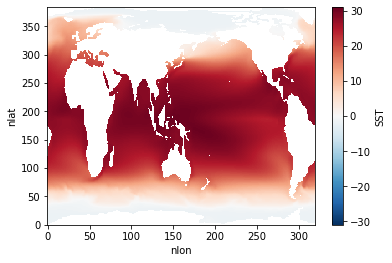

In [9]:
%%time
#SST_mean=ds.SST.isel(time=slice(0,10000)).mean(dim="time")[1,:,:].compute()
#SST_mean.plot()
sst_mean = ds.SST.isel(member_id=slice(0, 10)).isel(time=slice(0,10000)).mean(dim=["member_id","time"]).plot()

In [10]:
sst_mean = ds.SST.isel(member_id=slice(0, 10)).isel(time=slice(0,10000)).mean(dim=['member_id','time'])

## Map 

CPU times: user 7.59 s, sys: 136 ms, total: 7.72 s
Wall time: 57.1 s


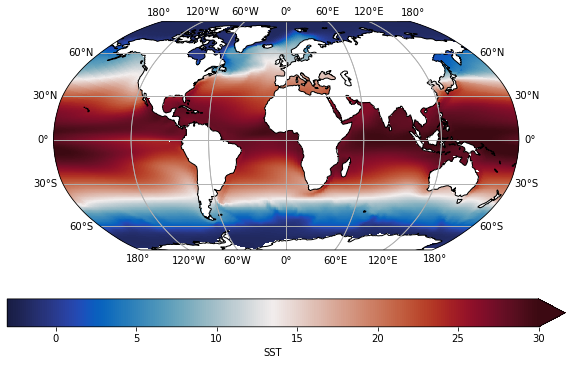

In [11]:
%%time
plt.figure(figsize=(10,6));
ax = plt.axes(projection=ccrs.Robinson());
#pc = ds.SST.isel(time=0, member_id=0).plot.pcolormesh(ax=ax,
pc = sst_mean.plot.pcolormesh(ax=ax,
                              transform=ccrs.PlateCarree(),
                              cmap=cmocean.cm.balance,
                              x='TLONG',
                              y='TLAT',
                              vmin=-3,
                              vmax=30,
                              cbar_kwargs={"orientation": "horizontal"})                                    
ax.gridlines(draw_labels=True);
ax.coastlines()
ax.gridlines()

In [ ]:
#dsp = util.pop_add_cyclic(ds)
#dsp

## Centralize the South Atlantic 

### Concatenation 

In [12]:
sa_ds=xr.combine_nested([
     [ds.isel(nlat = slice(20,280),nlon = slice(290,320)),
      ds.isel(nlat = slice(20,280),nlon = slice(0,60))]],
    concat_dim=['nlat','nlon']
)

### Map

CPU times: user 670 ms, sys: 34 ms, total: 704 ms
Wall time: 11.1 s


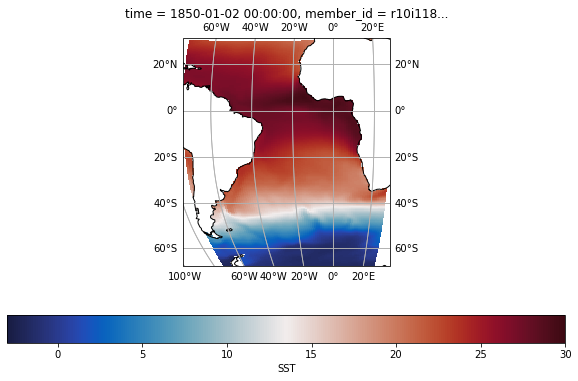

In [13]:
%%time
plt.figure(figsize=(10,6));
ax = plt.axes(projection=ccrs.Robinson());
pc = sa_ds.SST.isel(time=0, member_id=0).plot.pcolormesh(ax=ax,
                              transform=ccrs.PlateCarree(),
                              cmap=cmocean.cm.balance,
                              x='TLONG',
                              y='TLAT',
                              vmin=-3,
                              vmax=30,
                              cbar_kwargs={"orientation": "horizontal"})                                    
ax.gridlines(draw_labels=True);
ax.coastlines()
ax.gridlines()